In [1]:
pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tarfile
from netCDF4 import Dataset
import os

# Define the path to the tar.gz file and the extraction directory
tar_gz_path = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\example_output.tar.gz"
extraction_dir = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)"

In [4]:
# Directory containing the NetCDF files
data_dir = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\SURFACEMODEL"
data_routing_dir = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\ROUTING"

In [6]:
import os
import xarray as xr
# Function to recursively find all .nc files in a directory
def find_nc_files(directory):
    nc_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.nc'):
                nc_files.append(os.path.join(root, file))
    return nc_files

In [8]:
# Find all .nc files in each directory
surface_files = find_nc_files(data_dir)
routing_files = find_nc_files(data_routing_dir)

# Check if files were found
print(f'Found {len(surface_files)} files in surfacemodel')
print(f'Found {len(routing_files)} files in routing')

# Load datasets
ds_surface = xr.open_mfdataset(surface_files, combine='by_coords')
ds_routing = xr.open_mfdataset(routing_files, combine='by_coords')

Found 15339 files in surfacemodel
Found 5113 files in routing


In [11]:
print(ds_surface)

<xarray.Dataset>
Dimensions:          (time: 5113, north_south: 36, east_west: 34,
                      SoilMoist_profiles: 4)
Coordinates:
  * time             (time) datetime64[ns] 2010-01-02 2010-01-03 ... 2024-01-01
Dimensions without coordinates: north_south, east_west, SoilMoist_profiles
Data variables:
    lat              (time, north_south, east_west) float32 dask.array<chunksize=(1, 36, 34), meta=np.ndarray>
    lon              (time, north_south, east_west) float32 dask.array<chunksize=(1, 36, 34), meta=np.ndarray>
    SoilMoist_tavg   (time, SoilMoist_profiles, north_south, east_west) float32 dask.array<chunksize=(1, 4, 36, 34), meta=np.ndarray>
    TWS_tavg         (time, north_south, east_west) float32 dask.array<chunksize=(1, 36, 34), meta=np.ndarray>
    Streamflow_tavg  (time, north_south, east_west) float32 dask.array<chunksize=(1, 36, 34), meta=np.ndarray>
Attributes: (12/15)
    missing_value:           -9999.0
    NUM_SOIL_LAYERS:         4
    SOIL_LAYER_THICKNE

In [9]:
# Calculate the average soil moisture over a period

# Extract the soil moisture data
soil_moisture = ds_surface['SoilMoist_tavg']

# Calculate the average soil moisture over time, across all profiles, and spatial dimensions
soil_moisture_avg = soil_moisture.mean(dim=['time', 'SoilMoist_profiles', 'north_south', 'east_west'])

# Print the result
print("Average Soil Moisture:", soil_moisture_avg.values)

Average Soil Moisture: 0.28944683


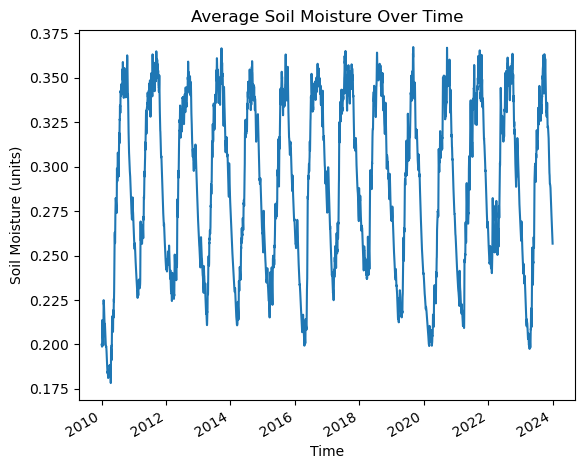

In [14]:
#Plot the Average Soil Moisture
import matplotlib.pyplot as plt

# Calculate the average soil moisture over time and plot it
soil_moisture_time_avg = soil_moisture.mean(dim=['SoilMoist_profiles', 'north_south', 'east_west'])

# Plot the time series of average soil moisture
soil_moisture_time_avg.plot()
plt.title('Average Soil Moisture Over Time')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (units)')
#plt.savefig('average_soil_moisture_plot.png', dpi=300, bbox_inches='tight')
plt.show()

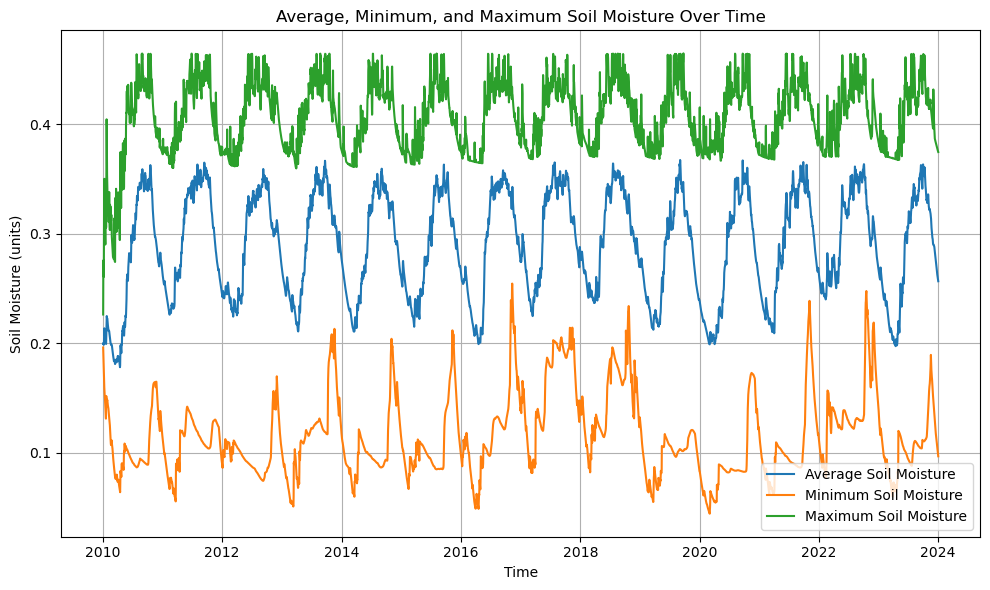

In [16]:
# Calculate statistics
soil_moisture_time_avg = soil_moisture.mean(dim=['SoilMoist_profiles', 'north_south', 'east_west'])
soil_moisture_time_min = soil_moisture.min(dim=['SoilMoist_profiles', 'north_south', 'east_west'])
soil_moisture_time_max = soil_moisture.max(dim=['SoilMoist_profiles', 'north_south', 'east_west'])

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plot average, minimum, and maximum soil moisture
plt.plot(soil_moisture_time_avg.time.values, soil_moisture_time_avg.values, label='Average Soil Moisture')
plt.plot(soil_moisture_time_avg.time.values, soil_moisture_time_min.values, label='Minimum Soil Moisture')
plt.plot(soil_moisture_time_avg.time.values, soil_moisture_time_max.values, label='Maximum Soil Moisture')

# Customize the plot
plt.title('Average, Minimum, and Maximum Soil Moisture Over Time')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (units)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()  # Adjust layout for better readability

#plt.savefig('time_soil_moisture_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [203]:
soil_moisture = ds_surface['SoilMoist_tavg']
TWS  = ds_surface['TWS_tavg']
STR  = ds_surface['Streamflow_tavg']

In [205]:
import pandas as pd
# Convert to DataFrames
soil_moisture_df = soil_moisture.to_dataframe().reset_index()
tws_df = TWS.to_dataframe().reset_index()
streamflow_df = STR.to_dataframe().reset_index()

# Merge DataFrames
merged_df = pd.merge(soil_moisture_df, tws_df, on=['time', 'north_south', 'east_west'])
merged_df = pd.merge(merged_df, streamflow_df, on=['time', 'north_south', 'east_west'])

# Calculate correlation coefficients
correlation_soil_moisture_tws = merged_df['SoilMoist_tavg'].corr(merged_df['TWS_tavg'])
correlation_soil_moisture_streamflow = merged_df['SoilMoist_tavg'].corr(merged_df['Streamflow_tavg'])
correlation_tws_streamflow = merged_df['TWS_tavg'].corr(merged_df['Streamflow_tavg'])

print('Correlation between Soil Moisture and TWS:', correlation_soil_moisture_tws)
print('Correlation between Soil Moisture and Streamflow:', correlation_soil_moisture_streamflow)
print('Correlation between TWS and Streamflow:', correlation_tws_streamflow)

Correlation between Soil Moisture and TWS: 0.887620691567946
Correlation between Soil Moisture and Streamflow: 0.14613450958037294
Correlation between TWS and Streamflow: 0.19191500184336022


In [211]:
# Rechunk the dataset
ds_surface_rechunked = ds_surface.chunk({'time': -1, 'north_south': 18, 'east_west': 17})

In [213]:
import numpy as np
from sklearn.linear_model import LinearRegression

def calc_trend(time_series):
    time_values = np.arange(len(time_series)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(time_values, time_series)
    return model.coef_[0]

# Apply trend calculation
tws_rechunked = ds_surface['TWS_tavg'].chunk({'time': -1})
tws_trend = xr.apply_ufunc(
    calc_trend, tws_rechunked, vectorize=True,
    input_core_dims=[['time']],
    dask='parallelized',
    output_dtypes=[float]
)

In [219]:
# Calculate the trend
def calc_trend(data):
    time = np.arange(len(data))
    slope, intercept, r_value, p_value, std_err = linregress(time, data)
    return slope

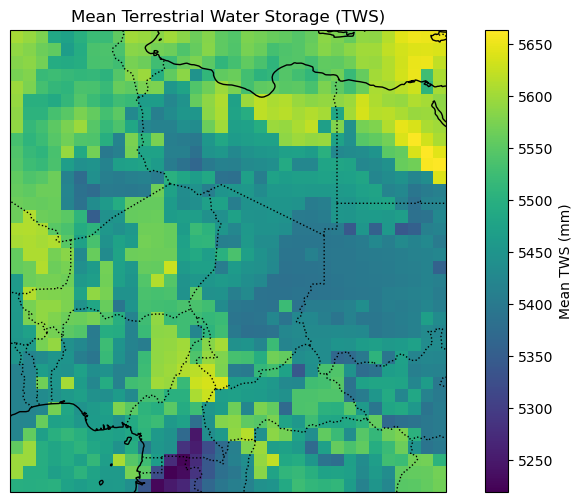

In [221]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress

# Define the map projection
projection = ccrs.PlateCarree()


plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
tws_mean.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'Mean TWS (mm)'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_title('Mean Terrestrial Water Storage (TWS)')
plt.show()

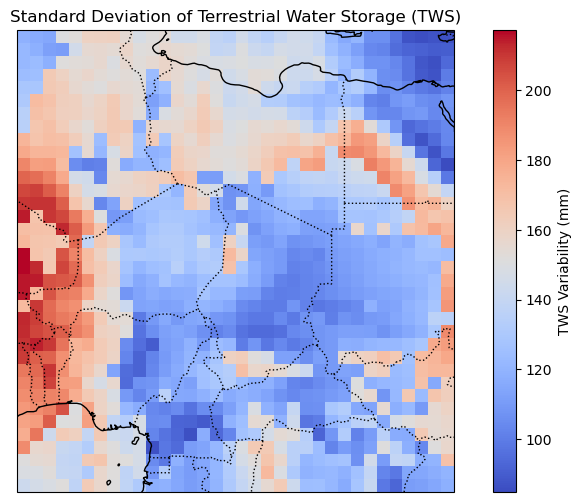

In [223]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
tws_std.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': 'TWS Variability (mm)'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_title('Standard Deviation of Terrestrial Water Storage (TWS)')
plt.show()

In [217]:
# Compute summary statistics
mean_soil_moisture = ds_surface['SoilMoist_tavg'].mean().values
std_soil_moisture = ds_surface['SoilMoist_tavg'].std().values

mean_tws = ds_surface['TWS_tavg'].mean().values
std_tws = ds_surface['TWS_tavg'].std().values

print(f"Mean Soil Moisture: {mean_soil_moisture}, Std Dev: {std_soil_moisture}")
print(f"Mean TWS: {mean_tws}, Std Dev: {std_tws}")

Mean Soil Moisture: 0.2894468307495117, Std Dev: 0.0687316358089447
Mean TWS: 5490.47705078125, Std Dev: 160.35804748535156


In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Example: Standardization
scaler = StandardScaler()
tws_scaled = scaler.fit_transform(ds_surface['TWS_tavg'].values.reshape(-1, 1))

In [15]:
tws_scaled.shape

(6258312, 1)

In [11]:
# Example: Splitting time series data
train_size = int(len(tws_scaled) * 0.8)
train, test = tws_scaled[:train_size], tws_scaled[train_size:]

In [15]:
import pandas as pd
import numpy as np

def prepare_features_and_target(series, n_lags=1):
    """
    Prepares features and target from a time series with lagged features.
    """
    df = pd.DataFrame(series, columns=['value'])
    
    # Create lagged features
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['value'].shift(lag)
    
    # Drop rows with NaN values
    df = df.dropna()
    
    # Define target and features
    y = df['value'].values #X: Features DataFrame with lagged values.
    X = df.drop('value', axis=1).values #y: Target variable (future values)

    return X, y

In [17]:
# Define the number of lags
n_lags = 3  #based on needs

# Prepare features and targets
X_train, y_train = prepare_features_and_target(train, n_lags=n_lags)
X_test, y_test = prepare_features_and_target(test, n_lags=n_lags)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Example: Fit ARIMA model
model = ARIMA(train, order=(1,1,1))  # Replace p, d, q with chosen parameters
model_fit = model.fit()

In [25]:
import pandas as pd
import numpy as np

def prepare_features_and_target(series, n_lags=1):

    df = pd.DataFrame(series, columns=['value'])
    
    # Create lagged features
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['value'].shift(lag)
    
    # Drop rows with NaN values
    df = df.dropna()
    
    # Define target and features
    y = df['value'].values
    X = df.drop('value', axis=1).values

    return X, y

In [27]:
import xgboost as xgb

# Example: Prepare data for XGBoost
X_train, y_train = prepare_features_and_target(train)  # Define this function based on data
dtrain = xgb.DMatrix(X_train, label=y_train)

# Train XGBoost model
params = {'objective': 'reg:squarederror', 'max_depth': 6}
model = xgb.train(params, dtrain, num_boost_round=100)

In [29]:
# Example: Forecasting and evaluation
forecast = model_fit.forecast(steps=len(test))
# Evaluate performance

In [37]:
import xgboost as xgb

# Convert training and testing data to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [41]:
# Train model
params = {'objective': 'reg:squarederror', 'max_depth': 6}
model = xgb.train(params, dtrain, num_boost_round=100)

In [43]:
# Make predictions on the test set
predictions = model.predict(dtest)

In [45]:
# Evaluate performance
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.17114457488059998


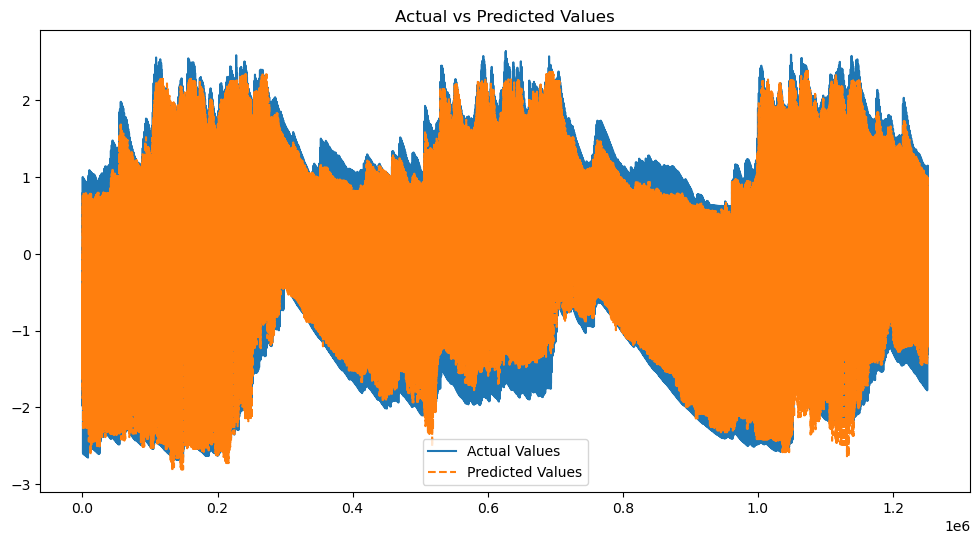

In [49]:
import matplotlib.pyplot as plt

# Example: Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(predictions, label='Predicted Values', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

In [51]:
#explore different hyperparameters Define the Parameter Grid:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [53]:
from sklearn.model_selection import GridSearchCV

# Define XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE for scoring
    cv=3,  # Number of cross-validation folds
    verbose=1,
    n_jobs=-1  # Use all available CPUs
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", -grid_search.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
4 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1081, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^

Best Parameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}
Best Score:  0.16888409356276193


In [57]:
from sklearn.model_selection import RandomizedSearchCV

# Define XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings to sample
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit random search
random_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", -random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters:  {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best Score:  0.16892419258753458


In [59]:
# Use the best parameters to train the final model
best_params = random_search.best_params_
final_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
final_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = final_model.predict(X_test)

# Evaluate the performance
mse = mean_squared_error(y_test, predictions)
print(f"Test Set Mean Squared Error: {mse}")

Test Set Mean Squared Error: 0.16945292055606842


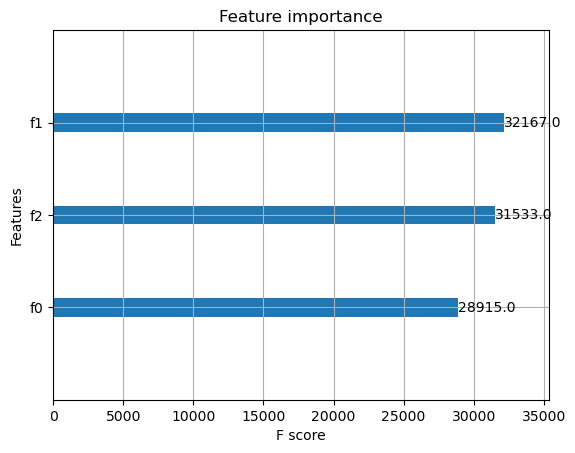

In [61]:
import matplotlib.pyplot as plt
xgb.plot_importance(final_model)
plt.show()

In [ ]:
#New

In [93]:
import numpy as np

# Extract latitude and longitude arrays
latitudes = ds_surface.lat[0, :, 0].values
longitudes = ds_surface.lon[0, 0, :].values

# Desired location
target_lat = 15.0
target_lon = 100.0

# Find the index of the closest latitude and longitude
lat_idx = np.abs(latitudes - target_lat).argmin()
lon_idx = np.abs(longitudes - target_lon).argmin()

print(f'Closest Latitude Index: {lat_idx}, Value: {latitudes[lat_idx]}')
print(f'Closest Longitude Index: {lon_idx}, Value: {longitudes[lon_idx]}')

Closest Latitude Index: 12, Value: 14.875
Closest Longitude Index: 10, Value: 99.875


In [95]:
# Select the time series using the indices
selected_time_series = ds_surface.TWS_tavg[:, lat_idx, lon_idx].to_series()

In [97]:
#Preprocess the Data
# Check for stationarity and apply differencing if needed
from statsmodels.tsa.stattools import adfuller

result = adfuller(selected_time_series)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -6.141466669138805
p-value: 7.952330530995512e-08


In [99]:
import pmdarima as pm

model = pm.auto_arima(selected_time_series, 
                      start_p=1, start_q=1,
                      max_p=5, max_q=5, 
                      seasonal=True, 
                      m=12,             # 'm' is the seasonal period (e.g., 12 for monthly seasonality)
                      trace=True,       
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=28937.412, Time=4.69 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=31347.467, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=29037.234, Time=1.40 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=29276.926, Time=2.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=31345.789, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=28936.435, Time=1.91 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=28958.201, Time=0.59 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=28937.701, Time=9.54 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=28935.932, Time=2.04 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=28937.560, Time=9.41 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=28938.936, Time=19.32 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=29273.276, Time=1.79 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=28936.050, Time=4.60 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=28931.065, Time=3.11 sec
 ARI

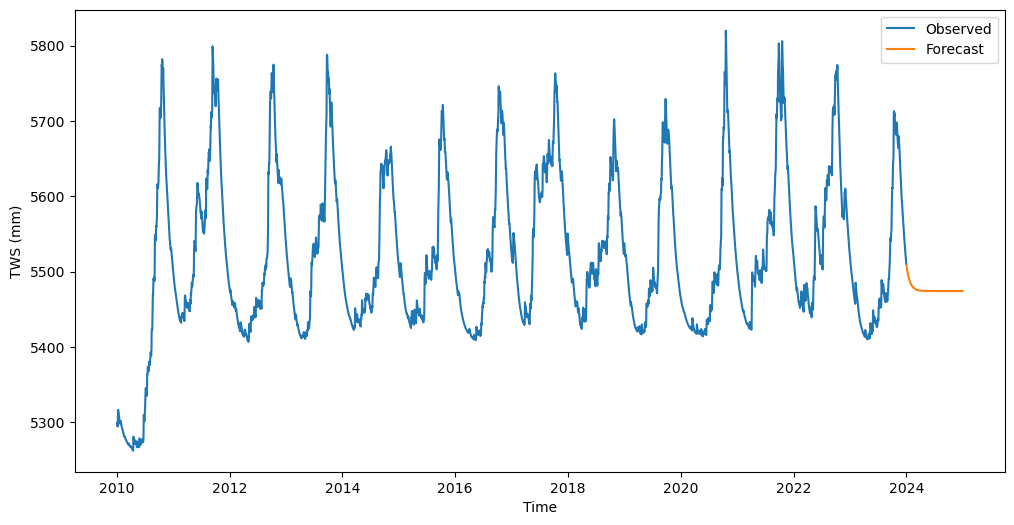

In [101]:
import matplotlib.pyplot as plt
import pandas as pd
# Fit the model with the selected parameters
model_fit = model.fit(selected_time_series)

# Forecasting the next 365 days
forecast = model_fit.predict(n_periods=365)

# Convert to pandas DataFrame for easier plotting
forecast_index = pd.date_range(start=selected_time_series.index[-1], periods=365, freq='D')
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(selected_time_series, label='Observed')
plt.plot(forecast_series, label='Forecast')
plt.xlabel('Time')
plt.ylabel('TWS (mm)')
plt.legend()

#plt.savefig('TWS_ARIMA_Forecast.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# In-sample forecast vs. actuals
fitted_values = model_fit.predict_in_sample()

# Evaluate performance
mse = mean_squared_error(selected_time_series, fitted_values)
mae = mean_absolute_error(selected_time_series, fitted_values)
print(f'MSE: {mse}, MAE: {mae}')
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(selected_time_series, fitted_values))
print(f'In-Sample RMSE: {rmse}')

MSE: 5509.456274816378, MAE: 3.2798322276455307
In-Sample RMSE: 74.22571168278805


In [105]:
import pmdarima as pm

arima_model = pm.auto_arima(selected_time_series, 
                            start_p=1, start_q=1,
                            max_p=5, max_q=5, 
                            seasonal=False,
                            stepwise=True,
                            suppress_warnings=True)
arima_forecast = arima_model.predict(n_periods=len(selected_time_series))

In [107]:
#ETS Model:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ets_model = ExponentialSmoothing(selected_time_series, 
                                 trend='add', 
                                 seasonal=None).fit()
ets_forecast = ets_model.forecast(steps=len(selected_time_series))

C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [109]:
#Prophet Model:
from prophet import Prophet

# Prepare the data for Prophet
df = pd.DataFrame({
    'ds': selected_time_series.index,  # Ensure 'ds' is the datetime column
    'y': selected_time_series.values
})

prophet_model = Prophet()
prophet_model.fit(df)

future = prophet_model.make_future_dataframe(periods=len(selected_time_series))
prophet_forecast = prophet_model.predict(future)['yhat'].values

14:46:20 - cmdstanpy - INFO - Chain [1] start processing
14:46:22 - cmdstanpy - INFO - Chain [1] done processing


In [111]:
# Ensure all forecasts are the same length
forecast_length = len(selected_time_series)

# ARIMA
arima_forecast = arima_model.predict(n_periods=forecast_length)

# ETS
ets_forecast = ets_model.forecast(steps=forecast_length)

# Prophet
future = prophet_model.make_future_dataframe(periods=forecast_length)
forecast = prophet_model.predict(future)
prophet_forecast = forecast['yhat'][-forecast_length:].values  # Adjust to match length

In [113]:
# Ensure forecasts are numpy arrays
arima_forecast = np.array(arima_forecast)
ets_forecast = np.array(ets_forecast)
prophet_forecast = np.array(prophet_forecast)

# Combine forecasts
ensemble_forecast = (arima_forecast + ets_forecast + prophet_forecast) / 3

# Calculate RMSE
rmse_ensemble = np.sqrt(mean_squared_error(selected_time_series[-forecast_length:], ensemble_forecast))
print(f"Ensemble RMSE: {rmse_ensemble}")

Ensemble RMSE: 2395.8813522360642


In [115]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE for individual models
arima_rmse = np.sqrt(mean_squared_error(selected_time_series, arima_forecast))
ets_rmse = np.sqrt(mean_squared_error(selected_time_series, ets_forecast))
prophet_rmse = np.sqrt(mean_squared_error(selected_time_series, prophet_forecast))

print(f"ARIMA RMSE: {arima_rmse}")
print(f"ETS RMSE: {ets_rmse}")
print(f"Prophet RMSE: {prophet_rmse}")

ARIMA RMSE: 115.8853855392922
ETS RMSE: 6879.458929486361
Prophet RMSE: 261.9986971491182


In [117]:
# Example weights based on individual model RMSE
weights = [1/arima_rmse, 1/ets_rmse, 1/prophet_rmse]
weights = np.array(weights) / np.sum(weights)  # Normalize to sum to 1

# Weighted average of forecasts
ensemble_forecast = (weights[0] * arima_forecast + 
                     weights[1] * ets_forecast + 
                     weights[2] * prophet_forecast)

# Calculate weighted RMSE
weighted_rmse = np.sqrt(mean_squared_error(selected_time_series, ensemble_forecast))
print(f"Weighted Ensemble RMSE: {weighted_rmse}")

Weighted Ensemble RMSE: 207.72236986207227


In [119]:
# Calculate weights based on RMSE
weights = np.array([1/arima_rmse, 1/prophet_rmse])  # Exclude ETS if it consistently performs poorly
weights = weights / np.sum(weights)  # Normalize to sum to 1

# Calculate weighted average forecast
ensemble_forecast = (weights[0] * arima_forecast + 
                     weights[1] * prophet_forecast)

# Compute RMSE for the refined ensemble
refined_rmse = np.sqrt(mean_squared_error(selected_time_series, ensemble_forecast))
print(f"Refined Ensemble RMSE: {refined_rmse}")

Refined Ensemble RMSE: 139.5587524897078


In [121]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
ensemble_rmse_scores = []

for train_index, test_index in tscv.split(selected_time_series):
    train, test = selected_time_series[train_index], selected_time_series[test_index]
    
    # Train models on training set
    arima_model = pm.auto_arima(train, 
                                start_p=1, start_q=1,
                                max_p=5, max_q=5, 
                                seasonal=False,
                                stepwise=True,
                                suppress_warnings=True)
    arima_forecast = arima_model.predict(n_periods=len(test))
    
    ets_model = ExponentialSmoothing(train, 
                                      trend='add', 
                                      seasonal=None).fit()
    ets_forecast = ets_model.forecast(steps=len(test))
    
    prophet_df = pd.DataFrame({'ds': test.index, 'y': test.values})
    prophet_model = Prophet()
    prophet_model.fit(prophet_df)
    future = prophet_model.make_future_dataframe(periods=len(test))
    forecast = prophet_model.predict(future)
    prophet_forecast = forecast['yhat'][-len(test):].values
    
    # Combine forecasts
    weights = np.array([1/arima_rmse, 1/prophet_rmse])  # Adjust weights if needed
    weights = weights / np.sum(weights)  # Normalize
    ensemble_forecast = (weights[0] * arima_forecast + 
                         weights[1] * prophet_forecast)
    
    # Calculate RMSE for ensemble
    rmse_ensemble = np.sqrt(mean_squared_error(test, ensemble_forecast))
    ensemble_rmse_scores.append(rmse_ensemble)

print(f"Average Ensemble RMSE from Cross-Validation: {np.mean(ensemble_rmse_scores)}")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17712\2985723327.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train, test = selected_time_series[train_index], selected_time_series[test_index]
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
14:48:00 - cmdstanpy - INFO - Chain [1] start processing
14:48:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17712\2985723327.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 

Average Ensemble RMSE from Cross-Validation: 149.1566675096206


In [123]:
from sklearn.ensemble import GradientBoostingRegressor

# Prepare training data
X_train = np.arange(len(train)).reshape(-1, 1)  # Using index as feature
y_train = train
X_test = np.arange(len(test)).reshape(-1, 1)

# Train Gradient Boosting Model
gbm = GradientBoostingRegressor(n_estimators=100)
gbm.fit(X_train, y_train)
gbm_forecast = gbm.predict(X_test)

In [125]:
from sklearn.metrics import mean_squared_error
gbm_rmse = np.sqrt(mean_squared_error(test, gbm_forecast))
print(f"GBM RMSE: {gbm_rmse}")

GBM RMSE: 208.7015249524489


In [127]:
# Define weights for the models
weights = np.array([1/arima_rmse, 1/prophet_rmse, 1/gbm_rmse])
weights = weights / np.sum(weights)  # Normalize weights

# Combine forecasts
ensemble_forecast = (weights[0] * arima_forecast + 
                     weights[1] * prophet_forecast + 
                     weights[2] * gbm_forecast)

# Calculate RMSE for the refined ensemble
refined_rmse = np.sqrt(mean_squared_error(test, ensemble_forecast))
print(f"Ensemble RMSE with GBM: {refined_rmse}")

Ensemble RMSE with GBM: 123.48319905477598


In [129]:
#Evaluate and Validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
ensemble_rmse_scores = []

for train_index, test_index in tscv.split(selected_time_series):
    train, test = selected_time_series[train_index], selected_time_series[test_index]
    
    # Train ARIMA model
    arima_model = pm.auto_arima(train, start_p=1, start_q=1, max_p=5, max_q=5, seasonal=False, stepwise=True, suppress_warnings=True)
    arima_forecast = arima_model.predict(n_periods=len(test))
    
    # Train Prophet model
    prophet_df = pd.DataFrame({'ds': test.index, 'y': test.values})
    prophet_model = Prophet()
    prophet_model.fit(prophet_df)
    future = prophet_model.make_future_dataframe(periods=len(test))
    forecast = prophet_model.predict(future)
    prophet_forecast = forecast['yhat'][-len(test):].values
    
    # Train GBM model
    X_train = np.arange(len(train)).reshape(-1, 1)
    y_train = train
    X_test = np.arange(len(test)).reshape(-1, 1)
    gbm = GradientBoostingRegressor(n_estimators=100)
    gbm.fit(X_train, y_train)
    gbm_forecast = gbm.predict(X_test)
    
    # Update ensemble weights
    weights = np.array([1/arima_rmse, 1/prophet_rmse, 1/gbm_rmse])
    weights = weights / np.sum(weights)  # Normalize
    ensemble_forecast = (weights[0] * arima_forecast + 
                         weights[1] * prophet_forecast + 
                         weights[2] * gbm_forecast)
    
    # Calculate RMSE for ensemble
    rmse_ensemble = np.sqrt(mean_squared_error(test, ensemble_forecast))
    ensemble_rmse_scores.append(rmse_ensemble)

print(f"Average Ensemble RMSE from Cross-Validation: {np.mean(ensemble_rmse_scores)}")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17712\1013955808.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train, test = selected_time_series[train_index], selected_time_series[test_index]
14:51:34 - cmdstanpy - INFO - Chain [1] start processing
14:51:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17712\1013955808.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train, test = selected_time_series[train_index], selected_time_series[test_index]
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users

Average Ensemble RMSE from Cross-Validation: 137.2936576390975


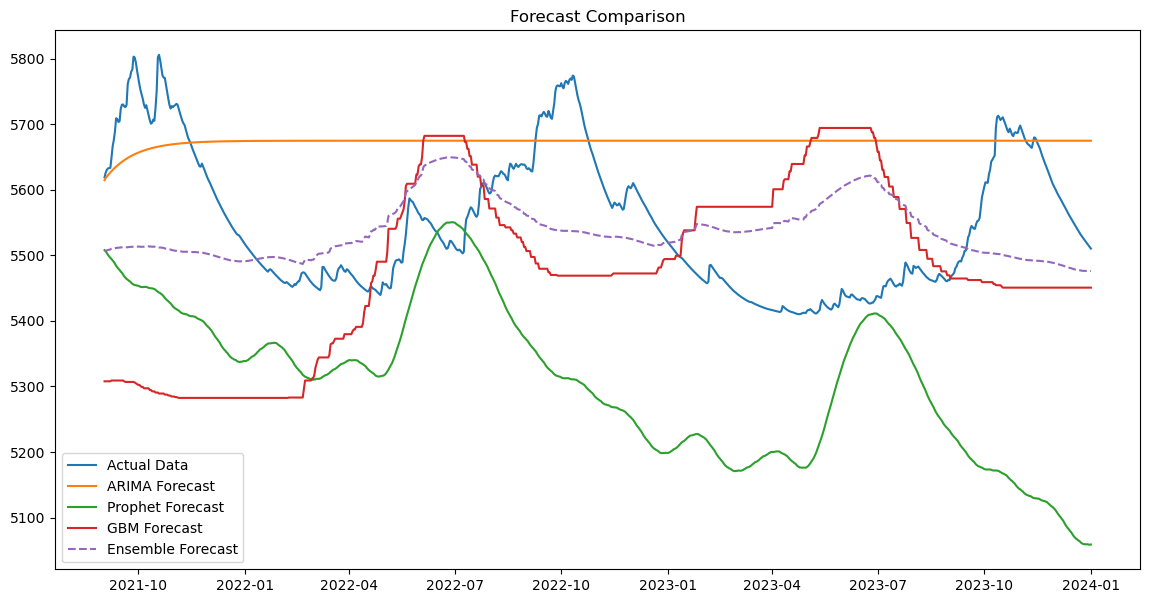

In [131]:
#Visualization and Interpretation
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, prophet_forecast, label='Prophet Forecast')
plt.plot(test.index, gbm_forecast, label='GBM Forecast')
plt.plot(test.index, ensemble_forecast, label='Ensemble Forecast', linestyle='--')
plt.legend()
plt.title('Forecast Comparison')
plt.show()

In [143]:
# Aggregate over spatial dimensions
ts_data = ds_surface['TWS_tavg'].mean(dim=['north_south', 'east_west'])

In [145]:
ts_df = ts_data.to_dataframe().reset_index()

In [147]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
ts_df['TWS_tavg'] = scaler.fit_transform(ts_df[['TWS_tavg']])

In [149]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Convert to numpy array
ts_values = ts_df['TWS_tavg'].values
seq_length = 30  # Example sequence length

In [151]:
X, y = create_sequences(ts_values, seq_length)

In [153]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [155]:
X_train_re = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_re = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [157]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_re, y_train, epochs=20, batch_size=32, validation_data=(X_test_re, y_test))

Epoch 1/20


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1787 - val_loss: 0.0024
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6181e-04 - val_loss: 9.2851e-04
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4037e-04 - val_loss: 7.6177e-04
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.4616e-04 - val_loss: 7.5714e-04
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.8905e-04 - val_loss: 5.7378e-04
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.0481e-04 - val_loss: 5.1979e-04
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2584e-04 - val_loss: 4.8441e-04
Epoch 9/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2464e-04 - val_loss: 4.5729e-04
Epoch 10/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9852e-04 - val_loss: 4.2546e-04
Epoch 11/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9747e-04 - val_loss: 4.

In [159]:
predictions = model.predict(X_test_re)
predictions = scaler.inverse_transform(predictions)  # Inverse transform if scaled

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [161]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 5501.0966796875


In [163]:
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(units=100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [165]:
model.fit(X_train_re, y_train, epochs=20, batch_size=32, validation_data=(X_test_re, y_test))

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.1231 - val_loss: 0.0013
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.4437e-04 - val_loss: 0.0017
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.8162e-04 - val_loss: 0.0013
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.0561e-04 - val_loss: 0.0015
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.0476e-04 - val_loss: 6.8801e-04
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.5163e-04 - val_loss: 6.4485e-04
Epoch 9/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.9381e-04 - val_loss: 6.3414e-04
Epoch 10/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.0818e-04 - val_loss: 0.0013
Epoch 11/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.5618e-04 - val_loss: 6.11

In [167]:
predictions_2 = model.predict(X_test_re)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [171]:
mse = mean_squared_error(y_test, predictions_2)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 0.026198837906122208


In [ ]:
# If scaled the data, inverse transform predictions and true values
#predictions = scaler.inverse_transform(predictions_2)
#y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape for inverse transform

# To align predictions with y_test_actual, ensure correct indexing
# If needed, reshape y_test_actual to match predictions

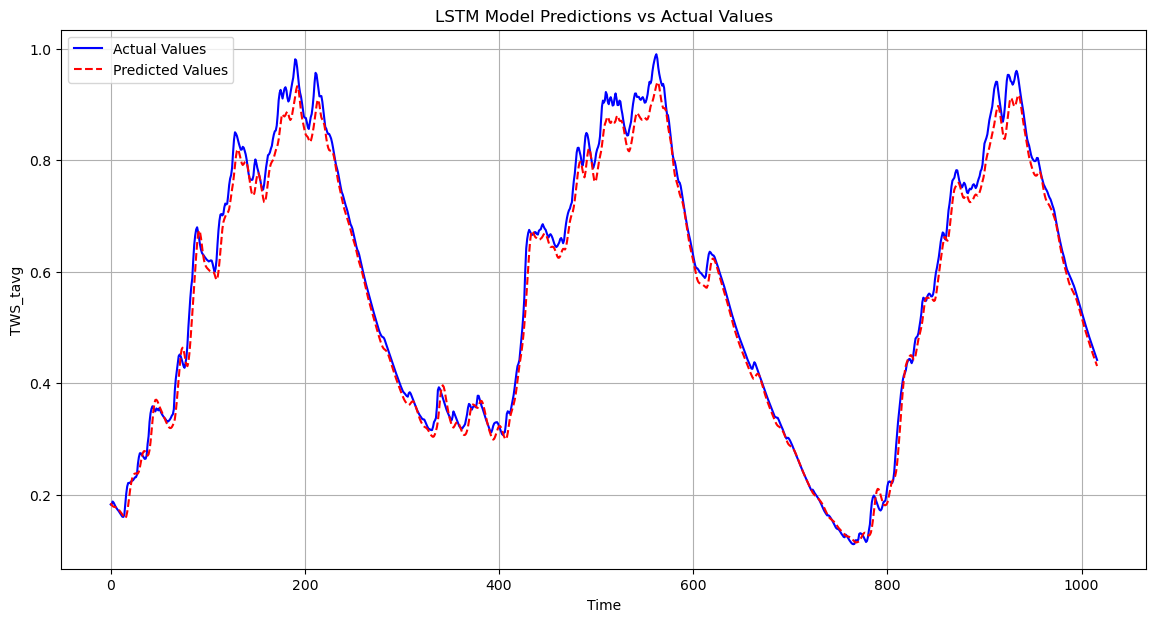

In [173]:
plt.figure(figsize=(14, 7))

# Plotting actual values
plt.plot(range(len(y_test)), y_test, color='blue', label='Actual Values')

# Plotting predictions
plt.plot(range(len(predictions_2)), predictions_2, color='red', linestyle='--', label='Predicted Values')

plt.title('LSTM Model Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('TWS_tavg')
plt.legend()
plt.grid(True)
plt.show()

In [177]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(X_train_re, y_train, epochs=50, batch_size=32, validation_data=(X_test_re, y_test), callbacks=[early_stopping])

Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.6159e-04 - val_loss: 5.1824e-04
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.5233e-04 - val_loss: 3.5887e-04
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.5308e-04 - val_loss: 2.4243e-04
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.4062e-04 - val_loss: 2.7626e-04
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.2543e-04 - val_loss: 8.4094e-04
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.3957e-04 - val_loss: 3.2780e-04
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.7089e-04 - val_loss: 0.0010
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.2691e-04 - val_loss: 4.7284e-04
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.9598e-04 - val_loss: 3.7616e-04
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.1051e-04 - val_loss: 0.0012
Epoch 11/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - l

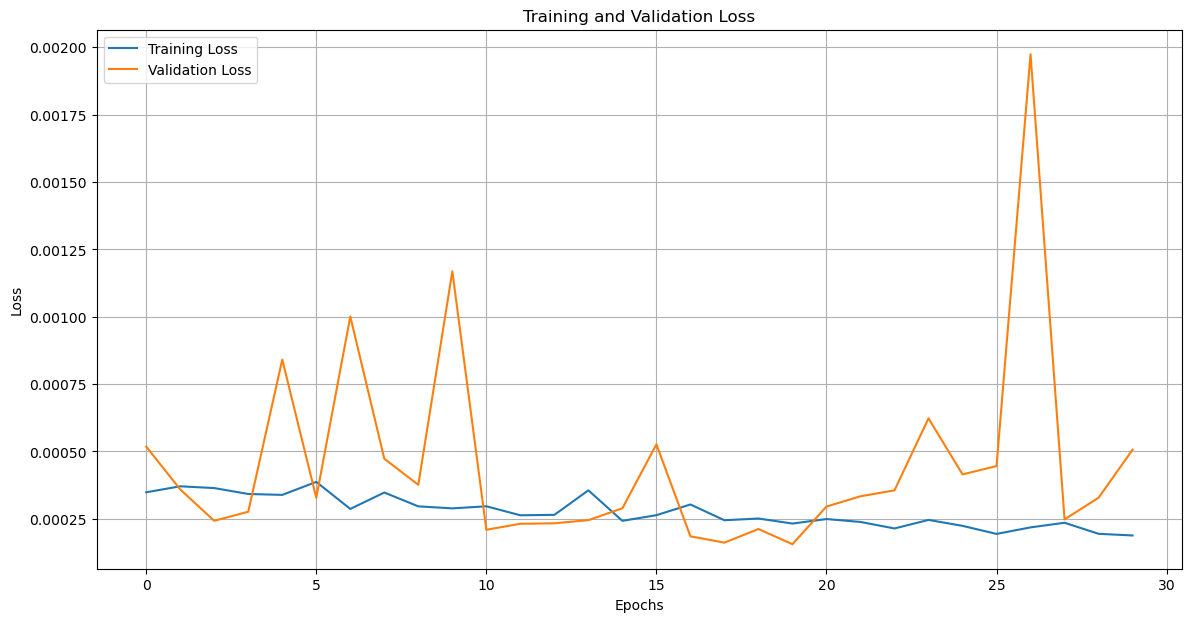

In [179]:
history = model.history.history

plt.figure(figsize=(14, 7))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [181]:
predictions_3 = model.predict(X_test_re)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


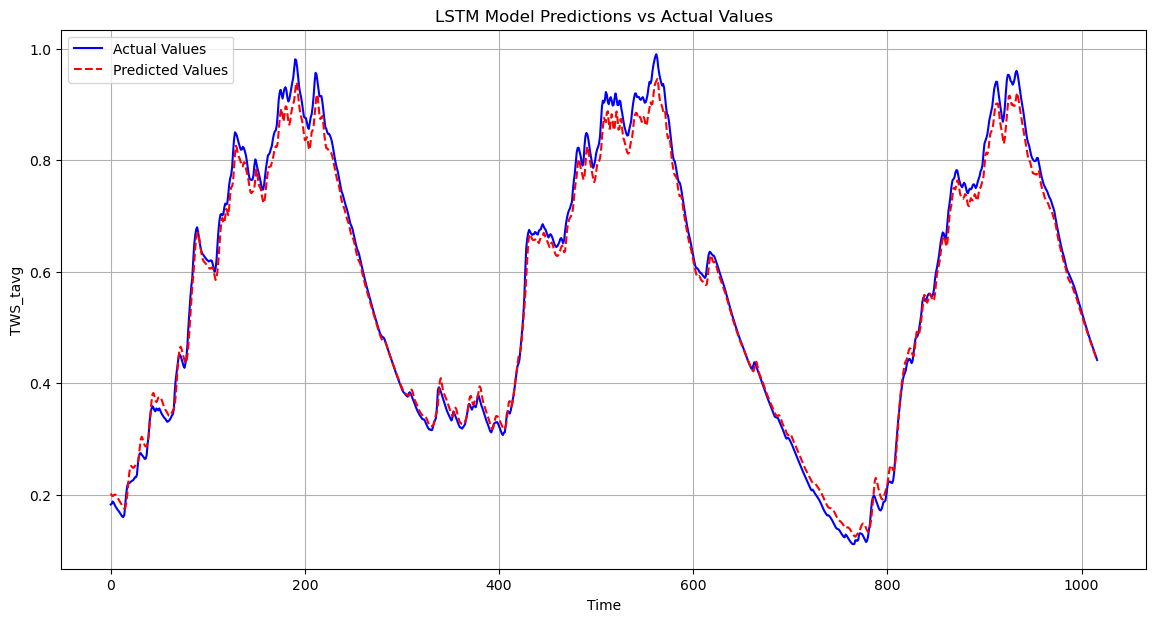

In [183]:
# Ensure predictions and y_test_actual are numpy arrays
predictions = np.array(predictions_3).flatten()
y_test_actual = np.array(y_test).flatten()

plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(range(len(y_test_actual)), y_test_actual, color='blue', label='Actual Values')

# Plot predictions
plt.plot(range(len(predictions)), predictions, color='red', linestyle='--', label='Predicted Values')

plt.title('LSTM Model Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('TWS_tavg')
plt.legend()
plt.grid(True)
plt.show()

In [185]:
mse = mean_squared_error(y_test, predictions_3)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 0.022505594417452812


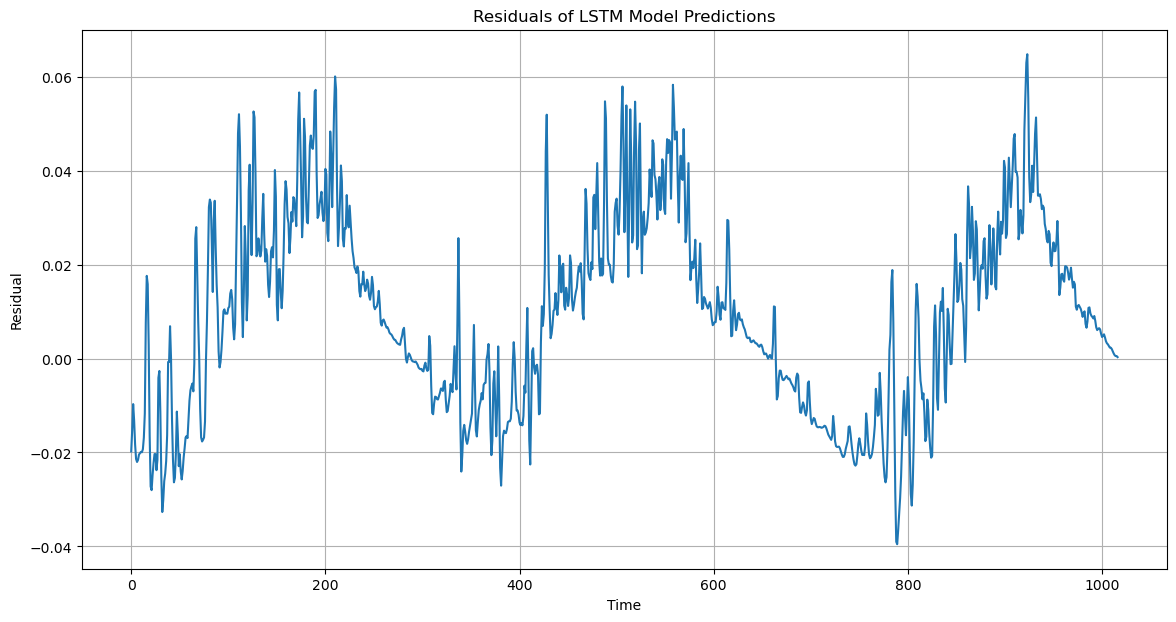

In [189]:
# Compute residuals
residuals = y_test_actual - predictions

plt.figure(figsize=(14, 7))
plt.plot(residuals)
plt.title('Residuals of LSTM Model Predictions')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.grid(True)
plt.show()